In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os

In [244]:
df = pd.read_csv(os.path.join('..', 'Resources', '../22-Big-Data/Trump_tweet.csv'))
df['polarity'] = df['is_quote_status'].apply(lambda x : 1 if x == 'TRUE' else 0)
is_quote_status_names = ['FALSE', 'TRUE']

In [245]:
df.head()

,favorited,contributors,truncated,is_quote_status,in_reply_to_status_id,user,geo,id,favorite_count,lang,...,Unnamed: 421,Unnamed: 422,Unnamed: 423,Unnamed: 424,Unnamed: 425,Unnamed: 426,Unnamed: 427,Unnamed: 428,Unnamed: 429,polarity
0,False,NaN,False,False,NaN,"{\follow_request_sent\"":false","\""has_extended_profile\"":false","\""profile_use_background_image\"":true","\""default_profile_image\"":false","\""id\"":25073877",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,False,NaN,False,False,9.480000e+17,"{\follow_request_sent\"":false","\""has_extended_profile\"":false","\""profile_use_background_image\"":true","\""default_profile_image\"":false","\""id\"":25073877",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,False,NaN,False,False,NaN,"{\follow_request_sent\"":false","\""has_extended_profile\"":false","\""profile_use_background_image\"":true","\""default_profile_image\"":false","\""id\"":25073877",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,False,NaN,False,False,NaN,"{\follow_request_sent\"":false","\""has_extended_profile\"":false","\""profile_use_background_image\"":true","\""default_profile_image\"":false","\""id\"":25073877",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,False,NaN,False,False,NaN,"{\follow_request_sent\"":false","\""has_extended_profile\"":false","\""profile_use_background_image\"":true","\""default_profile_image\"":false","\""id\"":25073877",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [246]:
df = df[pd.notnull(df['text'])]

In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2605 entries, 0 to 2604
Columns: 431 entries, favorited to polarity
dtypes: bool(3), float64(2), int64(1), object(425)
memory usage: 8.5+ MB


In [248]:
col = ['is_quote_status', 'text']
df = df[col]

In [249]:
df.columns

Index(['is_quote_status', 'text'], dtype='object')

In [250]:
df.columns = ['is_quote_status', 'text']

In [252]:
df['category_id'] = df['is_quote_status'].factorize()[0]
from io import StringIO
category_id_df = df[['is_quote_status', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'is_quote_status']].values)

In [253]:
df.head()

,is_quote_status,text,polarity,category_id
0,False,Will be leaving Florida for Washington (D.C.) ...,0,0
1,False,Iran is failing at every level despite the ter...,0,0
2,False,The United States has foolishly given Pakistan...,0,0
3,False,HAPPY NEW YEAR! We are MAKING AMERICA GREAT AG...,0,0
4,False,As our Country rapidly grows stronger and smar...,0,0


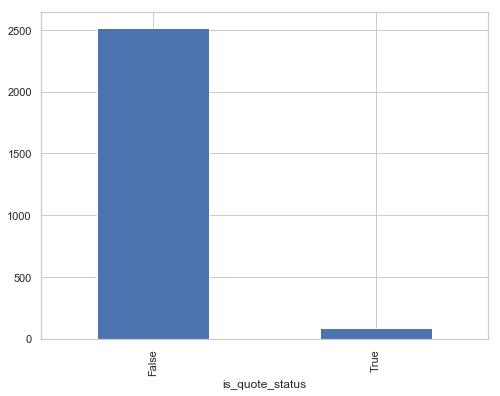

In [255]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('is_quote_status').text.count().plot.bar(ylim=0)
plt.show()

In [257]:

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.text).toarray()
labels = df.category_id
features.shape

(2605, 916)

In [259]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for is_quote_status, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(is_quote_status))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'False':
  . Most correlated unigrams:
       . thank
       . indices
  . Most correlated bigrams:
       . rt ivankatrump
       . id 818910970567344100
# 'True':
  . Most correlated unigrams:
       . thank
       . indices
  . Most correlated bigrams:
       . rt ivankatrump
       . id 818910970567344100


In [260]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['is_quote_status'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [261]:

print(clf.predict(count_vect.transform(["HAPPY NEW YEAR! We are MAKING AMERICA GREAT AGAIN, and much faster than anyone thought possible!."])))

[False]


In [262]:
print(clf.predict(count_vect.transform(["Iran, the Number One State of Sponsored Terror with numerous violations of Human Rights occurring on an hourly basis, has now closed down the Internet so that peaceful demonstrators cannot communicate. Not good!"])))

[False]


In [267]:
df[df['text'] == "HAPPY NEW YEAR! We are MAKING AMERICA GREAT AGAIN, and much faster than anyone thought possible!."]

,is_quote_status,text,polarity,category_id


In [265]:
df[df['text'] == "Iran, the Number One State of Sponsored Terror with numerous violations of Human Rights occurring on an hourly basis, has now closed down the Internet so that peaceful demonstrators cannot communicate. Not good!"]

,is_quote_status,text,polarity,category_id
5,False,"Iran, the Number One State of Sponsored Terror...",0,0


In [268]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\Hailu\OneDrive\Documents\PREWORK_HLS\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Hailu\OneDrive\Documents\PREWORK_HLS\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Hailu\OneDrive\Documents\PREWORK_HLS\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Hailu\OneDrive\Documents\PREWORK_HLS\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Hailu\OneDrive\Documents\PREWORK_HLS\Anaconda\l

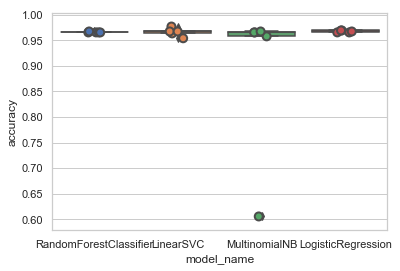

In [269]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [270]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.965840
LogisticRegression        0.967371
MultinomialNB             0.892269
RandomForestClassifier    0.965836
Name: accuracy, dtype: float64

In [271]:
from sklearn.model_selection import train_test_split

model = LogisticRegression()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\Users\Hailu\OneDrive\Documents\PREWORK_HLS\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


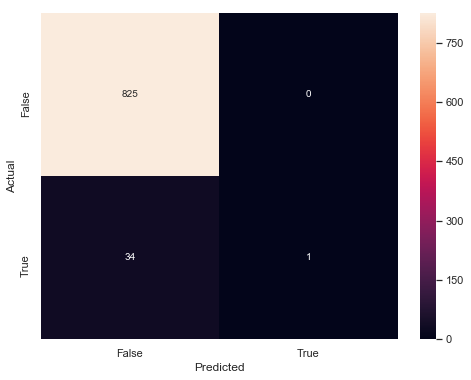

In [272]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.is_quote_status.values, yticklabels=category_id_df.is_quote_status.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [273]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['is_quote_status', 'text']])
      print('')

'True' predicted as 'False' : 34 examples.


,is_quote_status,text
913,True,"\""indices\"":[20"
1096,True,You are doing a great job - the world is watch...
1686,True,140]
921,True,"\""screen_name\"":\""IvankaTrump\"""
1192,True,"\""id\"":56561449"
271,True,A great guy (with great ratings)! https://t.co...
562,True,People get what is going on! https://t.co/Pdg7...
289,True,Another Crooked Hillary Fan! https://t.co/1Lid...
1078,True,"RT @DineshDSouza: Finally, as if by accident, ..."
1285,True,"\""indices\"":[18"


In [274]:
model.fit(features, labels)

C:\Users\Hailu\OneDrive\Documents\PREWORK_HLS\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [275]:
from sklearn.feature_selection import chi2

N = 2
for is_quote_status, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(is_quote_status))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'False':
  . Top unigrams:
       . https
       . indices
  . Top bigrams:
       . id 818910970567344100
       . rt ivankatrump


IndexError: index 1 is out of bounds for axis 0 with size 1

In [276]:
texts = ["Will be leaving Florida for Washington (D.C.) today at 4:00 P.M. Much work to be done, but it will be a great New Year!",
         "Iran is failing at every level despite the terrible deal made with them by the Obama Administration. The great Iranian people have been repressed for many years. They are hungry for food &amp; for freedom. Along with human rights, the wealth of Iran is being looted. TIME FOR CHANGE!",
         "The United States has foolishly given Pakistan more than 33 billion dollars in aid over the last 15 years, and they have given us nothing but lies &amp; deceit, thinking of our leaders as fools. They give safe haven to the terrorists we hunt in Afghanistan, with little help. No more!",
         "HAPPY NEW YEAR! We are MAKING AMERICA GREAT AGAIN, and much faster than anyone thought possible!",
         "As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"Will be leaving Florida for Washington (D.C.) today at 4:00 P.M. Much work to be done, but it will be a great New Year!"
  - Predicted as: 'False'

"Iran is failing at every level despite the terrible deal made with them by the Obama Administration. The great Iranian people have been repressed for many years. They are hungry for food &amp; for freedom. Along with human rights, the wealth of Iran is being looted. TIME FOR CHANGE!"
  - Predicted as: 'False'

"The United States has foolishly given Pakistan more than 33 billion dollars in aid over the last 15 years, and they have given us nothing but lies &amp; deceit, thinking of our leaders as fools. They give safe haven to the terrorists we hunt in Afghanistan, with little help. No more!"
  - Predicted as: 'False'

"HAPPY NEW YEAR! We are MAKING AMERICA GREAT AGAIN, and much faster than anyone thought possible!"
  - Predicted as: 'False'

"As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, 

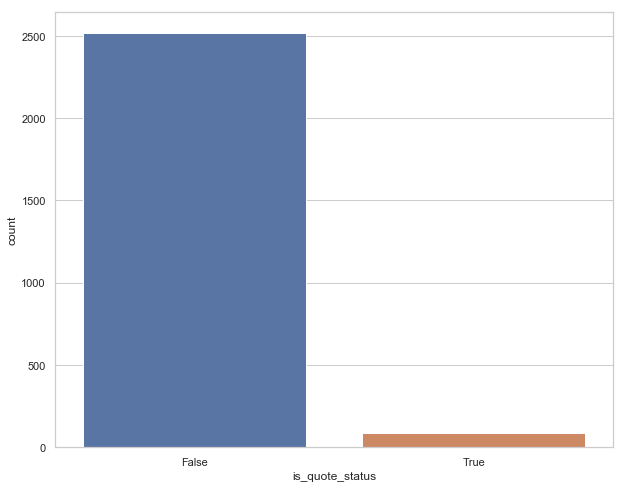

In [223]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.set(style="whitegrid")
ax = sns.countplot(x="is_quote_status", data=df)

Preprocessing through Tokenizing and using TFIDF

In [224]:
### nltk and string transformations
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string

### sklearn
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score

### numpy for seed.  Good practice for reproducibility, not something we touched on but worth wild to look further.
import numpy as np
from numpy import random

SEED = 1234

random.seed(SEED)

Before anything we need to take raw text and convert to numerical inputs for the machine learning algorithms.

The first step is to split the sentences into words, we will do this through a method of Tokenization (or splitting).

In [225]:
### Define simple space tokenizer
translator = str.maketrans('', '', string.punctuation)
tk = tokenize.simple.SpaceTokenizer()

def simple_tokenizer(x):
    x = x.translate(translator).strip().lower()
    return tk.tokenize(x)

### Quick look at what the tokenizer produces
print(df['text'].head().apply(lambda x : simple_tokenizer(x)))

### Developing the corpus or list of sentences for processing later
corpus = df['text'].tolist()
corpus[0:5]

0    [will, be, leaving, florida, for, washington, ...
1    [iran, is, failing, at, every, level, despite,...
2    [the, united, states, has, foolishly, given, p...
3    [happy, new, year, we, are, making, america, g...
4    [as, our, country, rapidly, grows, stronger, a...
Name: text, dtype: object


['Will be leaving Florida for Washington (D.C.) today at 4:00 P.M. Much work to be done, but it will be a great New Year!',
 'Iran is failing at every level despite the terrible deal made with them by the Obama Administration. The great Iranian people have been repressed for many years. They are hungry for food &amp; for freedom. Along with human rights, the wealth of Iran is being looted. TIME FOR CHANGE!',
 'The United States has foolishly given Pakistan more than 33 billion dollars in aid over the last 15 years, and they have given us nothing but lies &amp; deceit, thinking of our leaders as fools. They give safe haven to the terrorists we hunt in Afghanistan, with little help. No more!',
 'HAPPY NEW YEAR! We are MAKING AMERICA GREAT AGAIN, and much faster than anyone thought possible!',
 'As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 wi

We will now use the tokenizer within the TFIDF vectorizer. The words might sound intimidating yet simply yet in reality basically we just counting the number of times a words occur within the sentence relative to the whole sample (sometimes called a corpus).

In [226]:
vectorizer = TfidfVectorizer(tokenizer=simple_tokenizer, stop_words='english')
tf = vectorizer.fit(corpus)
X = tf.transform(corpus)

### Combining result of TFIDF with `target` columns
full_df = pd.concat([pd.DataFrame(X.toarray()), df['polarity']], axis=1)
print("Vector features : ", vectorizer.get_feature_names()[0:20])
print("Vector shape/size : ",X.shape)

Vector features :  ['', '\n\ngod', '\n\nhappy', '\n\ni', '\n\nnow', '\n\nsquare', '\n\nthe', '\n\nwe', '\narmynavygame', '\ndow23k', '\ndownud83dudcc9315', '\nendingwaroncoal', '\nhttpstco70iphy2yqn', '\nhttpstco8n4abo9ihp', '\nhttpstcou2026', '\nncaachampionsud83cudfc6photos', '\nprstrongud83cuddf5ud83cuddf7', '\nread', '\nrealdonaldtrump', '\nu2611ufe0fnasdaq']
Vector shape/size :  (2605, 4769)


Splitting data into a train and test datasets, using the predefined SEED from numpy for the split.

In [227]:
target_col = 'polarity'
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(full_df.drop(target_col, axis=1)
                                                    ,y, test_size=0.20, random_state=SEED)
print(X_train.shape, y_train.shape)

(2084, 4769) (2084,)


Model Training and Analysis
Helper Function : This is a simple helper function modified from the sklearn documentation. Example below. Parameters required are the actual labels (y_true), the predicted labels (y_pred), classes in a list like ["good", "bad", "ugly"]. Options are using normalize to get percentages, include_cm to print off the raw confusion matrix, and fig_size for the size of the plot.

In [228]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          include_cm=False,
                          fig_size=(10, 8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    from sklearn.utils.multiclass import unique_labels
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if include_cm:
        print(cm)

    fig, ax = plt.subplots(figsize=fig_size)
    ax.grid(False)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Lets use a base model to get a baseline prediction.

In [229]:
clf = MultinomialNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)

C:\Users\Hailu\OneDrive\Documents\PREWORK_HLS\Anaconda\lib\site-packages\sklearn\naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -


In [230]:
confusion_matrix(y_test, y_pred)

array([[521]], dtype=int64)

In [231]:
print("Accuracy of base model is {:.2f} %".format(accuracy_score(y_test, y_pred)*100))

Accuracy of base model is 100.00 %


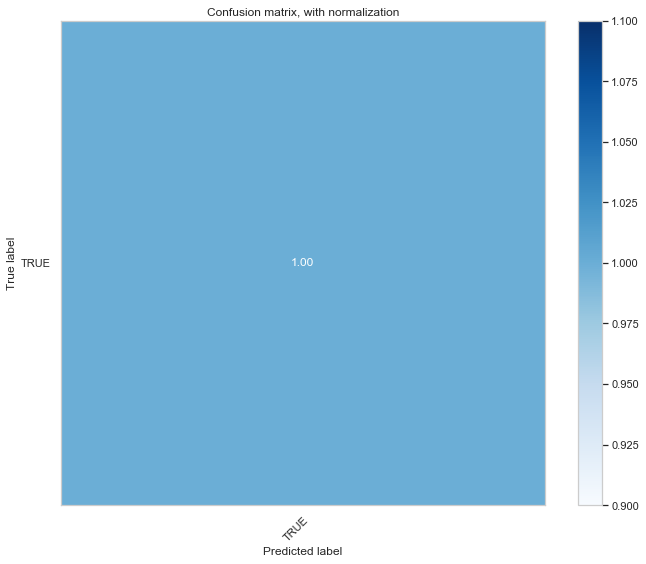

In [232]:
### Plot confusion matrix to get a feel for model ability to predict correct label.
plot_confusion_matrix(y_test, y_pred, classes=is_quote_status_names, normalize=True,
                      title='Confusion matrix, with normalization', fig_size=(10, 8));

Another try, let's try out using a Random Forest model.

In [233]:
clf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=SEED).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [234]:
confusion_matrix(y_test, y_pred)

array([[521]], dtype=int64)

In [235]:
print("Accuracy of base model is {:.2f} %".format(accuracy_score(y_test, y_pred)*100))

Accuracy of base model is 100.00 %


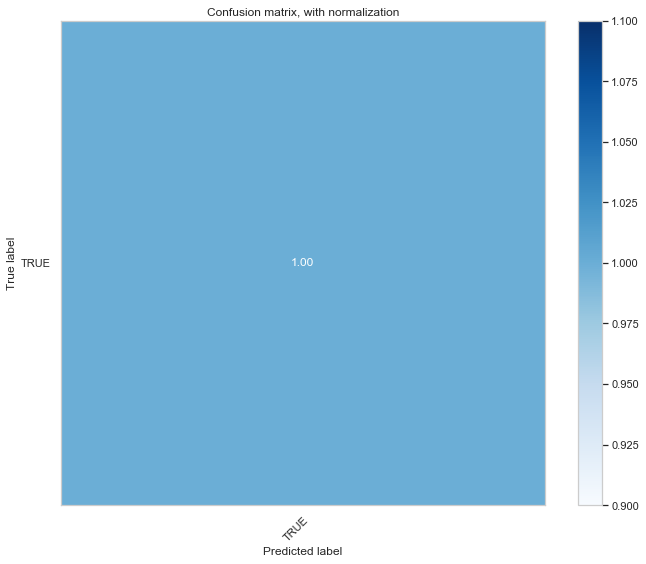

In [236]:
plot_confusion_matrix(y_test, y_pred, classes=is_quote_status_names, normalize=True,
                      title='Confusion matrix, with normalization', fig_size=(10, 8));

Single Input Examples

In [237]:
review = "Iran is failing at every level despite the terrible deal made with them by the Obama Administration. The great Iranian people have been repressed for many years. They are hungry for food &amp; for freedom. Along with human rights, the wealth of Iran is being looted. TIME FOR CHANGE!"

### Transform Review
review_transformed = tf.transform([review])

### Make Prediction
pred = clf.predict(review_transformed)

### Using the defined `class_names` get the predicted Polarity ( negative/positive )
print("Review was {}".format(is_quote_status_names[pred[0]]))

Review was TRUE


In [238]:
review = "The United States has foolishly given Pakistan more than 33 billion dollars in aid over the last 15 years, and they have given us nothing but lies &amp; deceit, thinking of our leaders as fools. They give safe haven to the terrorists we hunt in Afghanistan, with little help. No more!"

### Transform Review
review_transformed = tf.transform([review])

### Make Prediction
pred = clf.predict(review_transformed)

### Using the defined `class_names` get the predicted Polarity ( negative/positive )
print("Review was {}".format(is_quote_status_names[pred[0]]))

Review was TRUE


Extra Extra Content : Comparing Multiple Models Side by Side

In [239]:
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=8, random_state=SEED),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, solver='lbfgs'),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

### Gather all features (X values) and labels (y values) to pass through cross validation
features = full_df.drop(target_col, axis=1)
labels = df[target_col].values

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

C:\Users\Hailu\OneDrive\Documents\PREWORK_HLS\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0